### 0.0 Vorwort 

In diesem Projekt beschäftigen wir uns mit der Entwicklung und Evaluierung eines maschinellen Übersetzungsmodells, das auf der Transformer-Architektur basiert. Transformer haben sich als äußerst effektiv für sequenzielle Aufgaben wie maschinelle Übersetzung oder Textzusammenfassung erwiesen. Unser Ziel ist es, ein Modell zu trainieren, das Sequenzen von Englisch nach Deutsch und umgekehrt übersetzen kann und dieses dann auch auf eine gradio-App zu deployen.

Das folgende Jupyter Notebook beschreibt Schritt für Schritt, wie man das Transformer-Model trainiert und evaluiert. Dabei werden under the hood eine Vielzahl von Werkzeugen und Bibliotheken eingesetzt, darunter PyTorch, transformers oder tokenizers.

Im letzen Abschnitt wird eine Demo vorgestellt, die mithilfe von Gradio eine einfache Benutzeroberfläche bietet, um trainierte Models auch sinnvoll anwenden zu können. [Diese Demo kann auf Huggingface Spaces abgerufen werden.](https://huggingface.co/spaces/jesusbeamx3/transformer)

In [1]:
from torchinfo import summary
import warnings
import yaml
import os
import sys
from IPython.display import Image

from src.data import IWSLT2017DataLoader, Multi30kDataLoader
from utils.logger import get_logger
from src.seq2seq_transformer import Seq2SeqTransformer
from src.trainer import Trainer, EarlyStopper
from utils.config import SharedConfig, DataLoaderConfig, TransformerConfig, TrainerConfig
from src.processor import Processor
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

### 1.0 Dataloader and Tokenizer
Damit wir ein Transformer-Model überahupt trainieren können, müssen wir das zu verwendende Dataset (in diesem Fall Multi30k) erst vorbereiten.

1. Zunächst werden einige Variablen definiert:
    - `path_to_config`: Pfad zur Konfigurationsdatei (`'./configs/multi30k-small.yaml'`)
    - `run_id`: Eine eindeutige Kennung für den aktuellen Lauf (`'multi30k-small'`)
    - `device`: Das zu verwendende Gerät (`'cuda'`)
  
2. Ein Logger namens `"Main"` wird mithilfe der Funktion [get_logger()](./utils/logger.py) erstellt.

3. Es wird überprüft, ob bereits ein Verzeichnis mit dem Namen `./models/{run_id}/metrics` existiert. Falls ja, wird eine Fehlermeldungausgegeben und das Skript mit `sys.exit(1)` beendet. Andernfalls wird das Verzeichnis erstellt.

4. Die Konfigurationsdatei, die durch `path_to_config` spezifiziert ist, wird geöffnet und mit `yaml.safe_load()` geladen. Die geladene Konfiguration wird in der Variablen `config` gespeichert.

5. Ein [SharedConfig](./utils/config.py)-Objekt namens `shared_conf` wird mit der `run_id` erstellt.

6. Ein [DataLoaderConfig](./src/data.py)-Objekt namens `dl_conf` wird erstellt, indem die Werte aus `config['dataloader']` übergeben werden.

7. Basierend auf dem Wert von `dl_conf.dataset` wird entweder ein `IWSLT2017DataLoader` oder ein `Multi30kDataLoader` erstellt:
    - Wenn `dl_conf.dataset` gleich `"iwslt2017"` ist, wird `IWSLT2017DataLoader.new_instance()` aufgerufen, um einen neuen Datenloader zuerstellen.
    - Andernfalls wird `Multi30kDataLoader.new_instance()` aufgerufen, um einen neuen Datenloader zu erstellen. Der Parameter `back_translate`wird auf False gesetzt, da die Rückübersetzung sehr zeitaufwendig ist und zur Demonstration nicht notwendig ist.
    - Mit dem Backtranslating können wir effektiv ide vorhandene Datenmenge verdoppeln, da hier jede Target-Sequenz von einem anderenTranslation-Model in die Source-Sequenz übersetzt wird.

8. Die erstellten Datenloader, der Tokenizer und das Validierungsdataset werden in separaten Variablen gespeichert:
    - `train_dataloader`: Datenloader für das Training
    - `test_dataloader`: Datenloader für das Testen
    - `val_dataloader`: Datenloader für die Validierung
    - `tokenizer`: Der verwendete Tokenizer
    - `val_dataset`: Der Validierungsdatensatz
***
Das Multi30K Dataset besteht aus ca. 30.000 Seqeunzpaaren, die aus Bildbeschreibungen bestehen. Das IWSLT2017 Dataset, dass wir zum trainieren der beiden großen Models benutzt haben, besteht aus ca. 230.000 Sequenzpaaren, die aus kleineren Abschnitten aus TED Talks bestehen, daher ist es auch viel diverser was den Umfang der Sprache angeht.

Wir verwenden einen [WordPiece Tokenizer](./tokenizer/wordpiece_tokenizer.py), der alle Wörter, die in unserem Dataset vorkommen in die entsprechenden Subwords aufteilt - Dahinter steckt noch ein Byte Level Byte-Pair Encoding Tokenizer, mit dem es möglich ist alle möglichen Wörter mithilfe ihrer einzelnen Buchstaben zu konstruieren. Da es aber sehr ineffizient ist, Sequenzen in ihre einzelnen Buchstaben zu zerlegen, verwenden wir eben eine WordPiece Tokenizer. Diese Subwords stellen am Ende unsere Tokens dar. Im Vergleich zu einem WordLevel Tokenizer (Tokenizer, der nur die Wörter an sich tokenized), ist der WordPiece Tokenizer auch in der Lage Wörter abzubilden, die so nicht in unserem Dataset vorkommen. Damit schließen wir weitestgehend OOV (Out of Vocabulary) Tokens während des Testens und Evaluieren des Models aus, genauso während der Inference. Wenn zum Beispiel das Wort `kümmert` nicht in unserem Dataset vorkommt, dafür aber das Wort `kümmern`, kann der Tokenizer mit dem Subword `kümmer` und `t` (das `t` ist schon Teil unseres Basisvokabulars) zu dem Wort `kümmert` - `["kümmer", "##t"]` - zusammenfassen. Um Subwords zu kennzeichnen wird der Prefix `##` verwendet - das signalisiert dem Tokenizer, dass dieses Subword kein ganzes Wort darstellt. Um diese Subwords zu dem Vokabular des Tokenizers hinzuzufügen, müssen wir diesen trainieren - vor dem Training müssen die Sequenzen pre tokenized werden, damit wir den Tokenizer auf den einzelnen Wörtern in den Sequenzen trainieren können. Dabei können wir spezifzieren wie groß das Vokabular sein soll, wie wir unsere Sequenzen evtl. vorverarbeiten wollen (z.B. alle Apostrophe aus den Sequenzen entfernen), wie wir die Seqeunzen pre tokenizen wollen und wie oft einzelne Subwords in dem Dataset vorkommen müssen, bevor sie in das Vokabular aufgenommen werden.



In [2]:
path_to_config = './configs/multi30k-small.yaml'
run_id = 'multi30k-small'
device = 'cuda'

logger = get_logger("Main")
      
if os.path.exists(f'./models/{run_id}/metrics'):
      logger.error('Run ID already exists!')
      sys.exit(1)
else:
      os.makedirs(f'./models/{run_id}/metrics')
      
with open(path_to_config) as stream:
      config = yaml.safe_load(stream)

shared_conf = SharedConfig(run_id=run_id)
dl_conf = DataLoaderConfig(**config['dataloader'])

if dl_conf.dataset == "iwslt2017":
      dataloader = IWSLT2017DataLoader.new_instance(dl_conf, shared_conf)
else:
      # backtranslate False because it is very time consuming
      dataloader = Multi30kDataLoader.new_instance(dl_conf, shared_conf, back_translate=False)
            
train_dataloader = dataloader.train_dataloader
test_dataloader = dataloader.test_dataloader
val_dataloader = dataloader.val_dataloader
tokenizer = dataloader.tokenizer
val_dataset = dataloader.val_dataset

2024-07-25 21:52:19,943 | DataLoader | INFO : Datasets have benn loaded.


2024-07-25 21:54:44,957 | DataLoader | INFO : Dataloaders have been built.


### 2.0 Load Model and Processor

Nachdem wir die Datenloader vorbereitet haben, können wir nun das Transformer-Modell erstellen und konfigurieren.

1. Zunächst werden die vocabulary size für die Source- und Targetlanguage aus dem Tokenizer abgerufen und in den Variablen `SRC_VOCAB_SIZE` und `TGT_VOCAB_SIZE` gespeichert.

2. Ein [TransformerConfig](./utils/config.py)-Objekt namens `model_conf` wird erstellt, indem die Werte aus `config['transformer']` sowie die vocabulary sizes übergeben werden. Die Config für das Transformer-Model wird somit festgelegt.

3. Ein [Seq2SeqTransformer](./src/seq2seq_transformer.py)-Objekt namens `transformer` wird mit der zuvor erstellten Config `model_conf` instanziiert. Dieses Objekt stellt das eigentliche Transformer-Model dar.

4. Ein [Processor](./src/processor.py)-Objekt namens `translator` wird mithilfe der Funktion `from_instance()` erstellt. Dabei werden das `transformer`-Model, der `tokenizer` und das `device` übergeben. Der Processor dient dazu, die Source-Sequenzen zu verarbeiten und die Übersetzungen zu generieren.

5. Ein [TrainerConfig](./utils/config.py)-Objekt namens `trainer_conf` wird erstellt, indem die Werte aus `config['trainer']`, das `device` und die batch size aus `dl_conf.batch_size` übergeben werden. Die Config für den Trainer wird somit festgelegt.

6. Die Configs für `shared_conf`, `dl_conf`, `model_conf` und `trainer_conf` werden mithilfe der Funktion `model_dump()` ausgegeben, um einen Überblick über die verwendeten Configs zu erhalten.

7. Eine Zusammenfassung des `transformer`-Modells wird mithilfe der Funktion `summary()` erstellt. Dabei werden die Eingabedimensionen der Tensoren angegeben, um mithilfe der `forward()` Methode des `transformer`-Modells die Struktur und die Anzahl der Parameter des Modells zu visualisieren.

Wir trainineren hier ein klassisches Transformer-Model, wie es in dem Paper [Attention is All You Need](https://arxiv.org/abs/1706.03762) vorgestellt wurde bzw. der [PyTorch-Implementation](https://pytorch.org/tutorials/beginner/translation_transformer.html) davon. 
***
Das Transformer-Model besteht aus einem Encoder und einem Decoder, die beide aus mehreren Schichten aufgebaut sind. Jede einzelne Schicht besteht dabei aus einem Attention-Block und einem Feedforward-Network.

Der Encoder verarbeitet die Source-Sequenz und erzeugt daraus eine Kontext-Sequenz. Der Decoder generiert daraus schrittweise die Ausgabesequenz (z.B. die Übersetzung in der Zielsprache), indem er in jedem Schritt auf die Encoderausgabe, gegen die Target-Sequenz rechnet und die bisher generierten Wörter achtet (Attention).

An den Encoder und Decoder werden dabei nicht die Sequenzen selbst, sondern Positional Encodings bzw. Input/Output Embeddings dieser übergeben. Das hat den Vorteil, dass das Model nun nicht nur mit der Sequenz selsbt arbeiten muss, sondern auch weiß wo genau die Tokens in der Sequenz selbst stehen und wie ihr Abstand zueinander ist. Die Multi-Head-Attention in den Encoder- und Decoder Blöcken kann sich dann auf bestimmte Teilaspekte in den Sequenzen spezialisieren und somit besser die einzelnen Kontext-Informationen in den Sequenzen verarbeiten.

Am Ende des Transformer-Models steht dann noch ein Generator, der die entsprechenden Token ID's predicted, die dann vom Tokenizer in die Ausgabesequenz konvertiert werden können.

In [3]:
SRC_VOCAB_SIZE, TGT_VOCAB_SIZE = tokenizer.get_vocab_size(), tokenizer.get_vocab_size()

model_conf = TransformerConfig(
      **config['transformer'], 
      src_vocab_size=SRC_VOCAB_SIZE, 
      tgt_vocab_size=TGT_VOCAB_SIZE
)

transformer = Seq2SeqTransformer(model_conf)
translator = Processor.from_instance(transformer, tokenizer, device)

trainer_conf = TrainerConfig(
      **config['trainer'],
      device=device, 
      batch_size=dl_conf.batch_size
)

print(shared_conf.model_dump())
print(dl_conf.model_dump())
print(model_conf.model_dump())
print(trainer_conf.model_dump())

summary(transformer, [(256, dl_conf.batch_size), (256, dl_conf.batch_size), 
                      (256, 256), (256, 256), 
                      (dl_conf.batch_size, 256), (dl_conf.batch_size, 256)], depth=3)

{'special_symbols': ['<unk>', '<bos>', '<eos>', '<pad>'], 'src_language': 'en', 'tgt_language': 'de', 'run_id': 'multi30k-small'}
{'dataset': 'multi30k', 'batch_size': 128, 'num_workers': 4, 'pin_memory': True, 'drop_last': False, 'shuffle': True}
{'num_encoder_layers': 3, 'num_decoder_layers': 3, 'emb_size': 256, 'nhead': 4, 'src_vocab_size': 1640, 'tgt_vocab_size': 1640, 'dim_feedforward': 1024, 'dropout': 0.14}
{'learning_rate': 0.0005, 'num_epochs': 45, 'batch_size': 128, 'tgt_batch_size': 256, 'lr_scheduler': 'linear', 'warmup_steps': 1500}


Layer (type:depth-idx)                             Output Shape              Param #
Seq2SeqTransformer                                 [256, 128, 1640]          --
├─TokenEmbedding: 1-1                              [256, 128, 256]           --
│    └─Embedding: 2-1                              [256, 128, 256]           419,840
├─PositionalEncoding: 1-2                          [256, 128, 256]           --
│    └─Dropout: 2-2                                [256, 128, 256]           --
├─TokenEmbedding: 1-3                              [256, 128, 256]           --
│    └─Embedding: 2-3                              [256, 128, 256]           419,840
├─PositionalEncoding: 1-4                          [256, 128, 256]           --
│    └─Dropout: 2-4                                [256, 128, 256]           --
├─Transformer: 1-5                                 [256, 128, 256]           --
│    └─TransformerEncoder: 2-5                     [256, 128, 256]           --
│    │    └─ModuleList: 3

### 3.0 Train model
Nachdem das Transformer-Model erstellt und konfiguriert wurde, können wir mit dem Training beginnen.

1. Ein [EarlyStopper](./src/trainer.py)-Objekt namens `early_stopper` wird erstellt. Dabei werden folgende Parameter übergeben:

    - `warmup`=17: Die Anzahl der Epochen, in denen das Model trainiert, bevor das Early Stopping aktiviert wird.
    - `patience`=7: Die Anzahl der Epochen, in denen sich der test loss nicht verbessern muss, bevor das Training gestoppt wird.
    - `min_delt`a=0: Die minimale Verbesserung des validation loss, die als signifikant angesehen wird.
    Der EarlyStopper überwacht den Validierungsverlust während des Trainings und stoppt diese, wenn sich der test loss über eine bestimmte Anzahl von Epochen nicht ausreichend verbessert.

2. Ein [Trainer](./src/trainer.py)-Objekt namens trainer wird mithilfe der classmethod `new_instance()` erstellt. Dabei werden folgende Parameter übergeben:

    - `transformer`: Das zuvor erstellte Transformer-Model.
    - `translator`: Der zuvor erstellte Processor zur Verarbeitung der Eingabesequenzen.
    - `train_dataloader`: Der Dataloader für die Trainingsdaten.
    - `test_dataloader`: Der Dataloader für die Testdaten.
    - `val_dataloader`: Der Dataloader für die Validierungsdaten.
    - `tokenizer`: Der verwendete Tokenizer.
    - `early_stopper`: Der zuvor erstellte Early Stopper.
    - `trainer_conf`: Die Konfiguration für den Trainer.
    - `device`: Das zu verwendende Hardware (z.B. CPU oder GPU).
    - `run_id`: Die run id des Modells.
    - Der Trainer ist für die Durchführung des Trainingsprozesses verantwortlich. Er koordiniert das data loding, das Training und Optimieren des Modells und er überwacht inwieweit sich das Modell während des Trainings verbessert oder nicht verbessert.

3. Die Funktion `train()` des Trainers wird aufgerufen, um den Trainingsprozess zu starten. Während des Trainings werden die Trainingsdaten als Batches geladen, durch das Modell propagiert und die Parameter optimiert, um den loss zu minimieren. Der test loss wird regelmäßig berechnet, um den Fortschritt, den das Modell macht zu überwachen und ggf. das Training durch den `early_stopper` früher zu beenden.

In [4]:
early_stopper = EarlyStopper(warmup=17, patience=7, min_delta=0)

trainer = Trainer.new_instance(transformer, translator, train_dataloader, test_dataloader, val_dataloader, 
                               tokenizer, early_stopper, trainer_conf, device, run_id)

trainer.train()

2024-07-25 21:55:24,977 | Trainer | INFO : epoch 1 avg_training_loss: 6.708 (10.03s)
2024-07-25 21:55:25,448 | Trainer | INFO : epoch 1 avg_test_loss: 6.068 (0.47s)
2024-07-25 21:55:35,665 | Trainer | INFO : epoch 2 avg_training_loss: 5.566 (9.9s)
2024-07-25 21:55:36,087 | Trainer | INFO : epoch 2 avg_test_loss: 4.864 (0.421s)
2024-07-25 21:55:46,294 | Trainer | INFO : epoch 3 avg_training_loss: 4.498 (9.917s)
2024-07-25 21:55:46,735 | Trainer | INFO : epoch 3 avg_test_loss: 3.9 (0.44s)
2024-07-25 21:55:57,030 | Trainer | INFO : epoch 4 avg_training_loss: 3.711 (10.008s)
2024-07-25 21:55:57,493 | Trainer | INFO : epoch 4 avg_test_loss: 3.314 (0.462s)
2024-07-25 21:56:07,716 | Trainer | INFO : epoch 5 avg_training_loss: 3.224 (9.929s)
2024-07-25 21:56:08,176 | Trainer | INFO : epoch 5 avg_test_loss: 2.925 (0.459s)
2024-07-25 21:56:18,455 | Trainer | INFO : epoch 6 avg_training_loss: 2.872 (9.988s)
2024-07-25 21:56:18,876 | Trainer | INFO : epoch 6 avg_test_loss: 2.594 (0.42s)
2024-07-25

### 4.0 Model Evaluation

Im folgenden schauen wir uns verschiedene Kenngrößen an, durch die wir sehen können, wie das Training verlief und wie gut das trainierte Modell am Ende performt.

### 4.1 Learning Rate Scheduler

Die learning rate ist ein entscheidender Hyperparameter beim Training von neuronalen Netzen. Sie bestimmt, wie stark die Gewichte des Models bei jedem Optimierungsschritt angepasst werden. Eine zu hohe learning rate kann dazu führen, dass das Model instabil wird und nicht konvergiert, während eine zu niedrige learning rate zu einem langsamen Lernprozess und möglicherweise zu einem suboptimalen Ergebnis führt.

Ein Learning Rate Scheduler ermöglicht es, die learning rate während des Trainings anzupassen, um den Lernprozess zu verbessern:

1. Schnellere Konvergenz: Durch die Verwendung einer höheren learning rate zu Beginn des Trainings kann das Modell schneller konvergieren und sich einem lokalen oder besser noch dem optimalen Minimum innerhalb des Transformers nähern - das nennt man auch Warmup-Phase.

2. Bessere Generalisierung: Durch die schrittweise Verringerung der learning rate im Laufe des Trainings kann das Model besser generalisieren und eine höhere Genauigkeit auf ungesehenen Daten erzielen.

3. Vermeidung von Overfitting: Eine zu hohe learning rate kann dazu führen, dass das Model sich zu stark an die Trainingsdaten anpasst und eine schlechte Generalisierungsfähigkeit aufweist. Durch die Verringerung der learning rate im späteren Verlauf des Trainings kann dies vermieden werden.
***
Wir haben uns für einen [LinearWarmupDecay Learning Rate Scheduler](./src_trainer.py) entschieden, da dieser in unseren Tests und Trainings die besten Ergebnisse geliefert hat. Während der Warmup-Phase wird die learning rate linear erhöht, während learning rate im Laufe der Decay-Phase linear abnimmt. Alternativ könnten wir auch den InverseSquareRootLRScheduler einsetzen, der sich aber nur für längere Trainings gut eignet, da hier nach der Warmup-Phase die learning rate sehr lange braucht um gegen 0 zu gehen, da die Dacay-Phase nicht abhängig von den Epochen oder den Training steps ist.

Bis vor kurzem wies der Code für die beiden Learning Rate Scheduler Bugs auf, die dazu geführt haben, dass die learning rate nicht richtig berechnet wird. Das wurde aber mittlerweile gefixt.

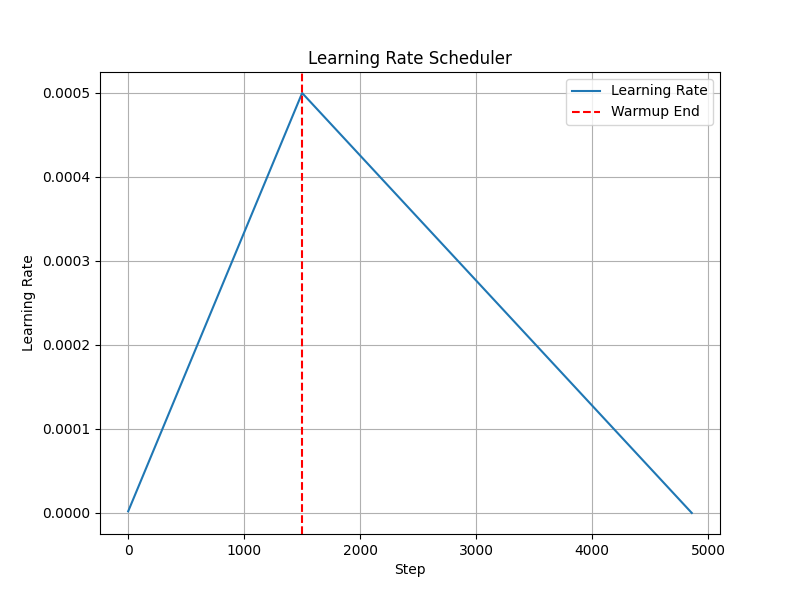

In [5]:
Image(filename=f'./models/{run_id}/metrics/learning_rate.png')

### 4.2 Training loss

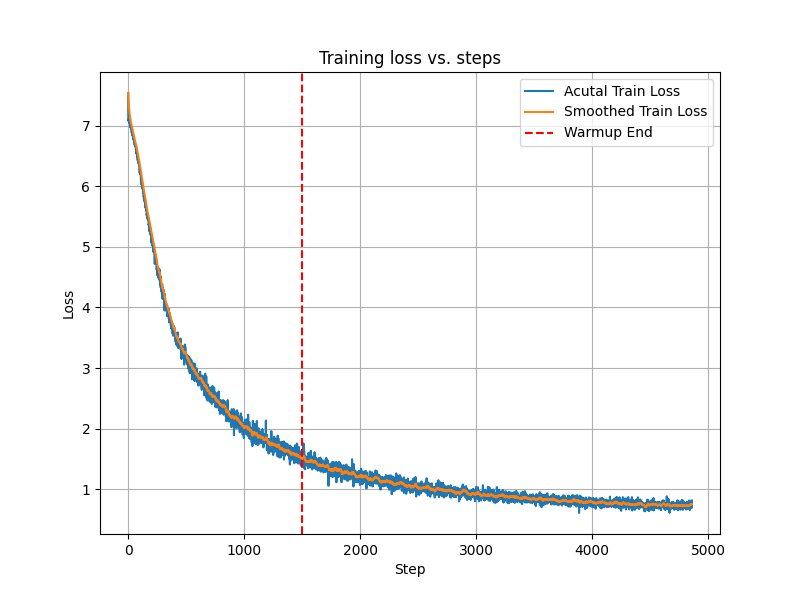

In [6]:
Image(filename=f'./models/{run_id}/metrics/train_loss.png')

### 4.3 Test loss

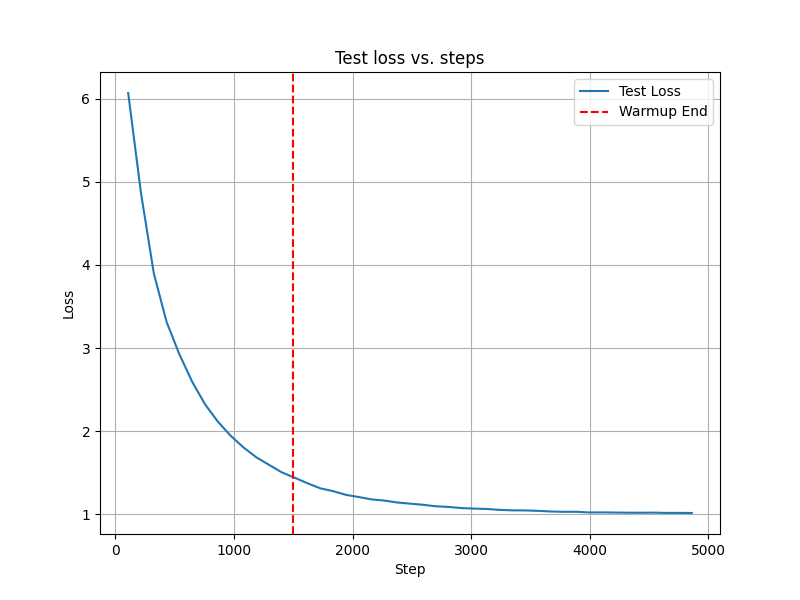

In [7]:
Image(filename=f'./models/{run_id}/metrics/test_loss.png')

### 4.4 Vorbereiten der Model Evaluation

Nach dem Training des Transformer-Models ist es wichtig, die Leistung des Models auf ungesehenen Daten zu evaluieren. In diesem Abschnitt wird das trainierte Model auf dem validation dataset evaluiert und es werden verschiedene Metriken berechnet.

1. Zunächst werden die benötigten Metriken (`bleu`, `sacre_bleu`, `rouge`, `meteor`) mithilfe der Funktion `load_metric()` aus der evaluate library geladen. (`bleu`und `sacrebleu`sind im Prinzip die gleiche Metrik)

2. Außerdem benutzen wir zum evaluieren unseres Modells das IWSLT22017 Dataset, welches eine uns eine hähere Datenmenge zur Verfügung stellt und gut geeignet ist um die Übersetzungsqualität der Model-Outputs zu überrpüfen.

3. Der path zum gespeicherten model checkpoint und Tokenizer wird festgelegt. Dabei wird überprüft, ob `best_checkpoint_scripted.pt`), `last_checkpoint_scripted.pt` oder `checkpoint_scripted.pt` im angegebenen model folder vorhanden ist. Der entsprechende path wird in der Variable `path_to_checkpoint` gespeichert - scripted.pt deswegen, weil wir die Models, die für die Inference benutzen in torchscript-models umwandeln, dass bietet den Vorteil, dass die Models dadurch für die Inference optimiert werden.

4. Die zu verwendende Hardware (CPU oder GPU) wird automatisch erkannt und in der Variable `device` gespeichert.

5. Ein [Processor](./src/processor.py)-Objekt namens translator wird mithilfe der Methode `from_checkpoint()` erstellt. Dabei werden der path zum model checkpoint (`path_to_checkpoint`), der path zum tokenizer (`path_to_tokenizer`) und das `device` übergeben. Der `Processor` dient dazu, die Eingabesequenzen zu verarbeiten und die Übersetzungen zu generieren.

6. Leere Listen `outputs`, `sources` und `targets` werden initialisiert, um die generierten Übersetzungen, die Source-Sequenzen und die Target-Sequenzen zu speichern.

7. Die Source-Sequenzen (`sources`) und Target-Sequenzen (`targets`) werden aus dem validation dataset (`val_dataset`) extrahiert. Dabei wird die Liste der Sequenzpaare entpackt und die Source-Sequenzen und Target-Sequenzen separat gespeichert.

Die eigentliche Evaluierung erfolgt im nächsten Schritt, bei dem das Model auf die Source-Sequenzen angewendet wird, um Übersetzungen zu generieren, und die generierten Übersetzungen mit den tatsächlichen Target-Sequenzen verglichen werden, um die Metriken zu berechnen.

In [8]:
from evaluate import load as load_metric
import torch

path_to_config = './configs/iwslt2017-small.yaml'
      
with open(path_to_config) as stream:
      config = yaml.safe_load(stream)

dl_conf = DataLoaderConfig(**config['dataloader'])

dataloader = IWSLT2017DataLoader.new_instance(dl_conf, shared_conf)
            
val_dataloader = dataloader.val_dataloader
val_dataset = dataloader.val_dataset

# If one want to evaluate another model that was not trained before through this notebook - 
# specify here the path to the model checkpoint and tokenizer:
# path_to_checkpoint = ""
# path_to_tokenizer = ""
# Don't forget to comment the paths below

model_dir = f"./models/{run_id}"
path_to_tokenizer = f"{model_dir}/tokenizer.json"

if os.path.isfile(f"{model_dir}/best_checkpoint_scripted.pt"):
    path_to_checkpoint = f"{model_dir}/best_checkpoint_scripted.pt"
elif os.path.isfile(f"{model_dir}/last_checkpoint_scripted.pt"):
    path_to_checkpoint = f"{model_dir}/last_checkpoint_scripted.pt"
else:
    path_to_checkpoint = f"{model_dir}/checkpoint_scripted.pt"
    
device = torch.device(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

translator = Processor.from_checkpoint(model_checkpoint=path_to_checkpoint, 
                                             tokenizer=path_to_tokenizer, 
                                             device=device)
      
bleu = load_metric("bleu")
sacre_bleu = load_metric("sacrebleu")
rouge = load_metric("rouge")
meteor = load_metric("meteor")

sources = [x[0] for x in val_dataset]
targets = [x[1] for x in val_dataset]

2024-07-25 22:03:39,453 | DataLoader | INFO : Datasets have been loaded.


2024-07-25 22:06:04,333 | DataLoader | INFO : Dataloaders have been built.


[nltk_data] Downloading package wordnet to /home/nico/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nico/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nico/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 4.5 Metriken berechnen

Um die Metriken zu berechnen übergeben wir nun die generierten Übersetzungen zusammen mit den Target-Sequenzen an die entsprechenden Funktionen.
Diese Funktionen berechnen dann die entsprechenden Metriken, die im nächsten Abschnitt beurteilt werden können.

Der [Trainer](./src/trainer.py) selbst bietet auch die Möglichkeit, das trainierte Model zu evaluieren, dort weist der Code aber noch Bugs auf, die dazu führen, dass die Sequenzen nicht richtig übersetzt und dadurch die Metriken verfälscht werden. Deshalb evaluieren wir nicht über den Trainer, sondern über den Processor. Der Unterschied besteht hier darin, dass der Processor in einer Schleife immer nur den nächsten Token übersetzt, während der Trainer, die ganze Sequenz auf einmal übersetzt.

In [ ]:
outputs = []
for idx, src in enumerate(sources):
    output = translator.translate(src)
            
    outputs.append(output)
            
    print(f"{idx+1}/{len(sources)}", end='\r')

### 4.5.1 Benchmark t5-model

Hier können wir uns die Übersetzungen von dem T5-Model generieren lassen, um darauf die Metriken zu berechen.

In [ ]:
# Beware this will overwrite the code cell above
from src.pretrained_inference import get_base_model, t5_inference

outputs = []

tokenizer, model = get_base_model(device)

for idx, src in enumerate(sources):
    output = t5_inference(tokenizer, model, src, device)
            
    outputs.append(output)
            
    print(f"{idx+1}/{len(sources)}", end='\r')

In [ ]:
import json

bleu_score = bleu.compute(predictions=outputs, references=targets)
            
sacre_bleu_score = sacre_bleu.compute(predictions=outputs, references=targets)
                                
rouge_score = rouge.compute(predictions=outputs, references=targets)
      
meteor_score = meteor.compute(predictions=outputs, references=targets)
      
metrics = {'bleu': bleu_score, 
           'sacre_bleu': sacre_bleu_score, 
           'rouge': rouge_score, 
           'meteor': meteor_score}
      
# Convert and write JSON object to file
with open(f"./models/{run_id}/metrics/metrics.json", "w") as outfile: 
    json.dump(metrics, outfile, indent=4)

### 4.6 Beurteilung der Metriken und Fazit

Wir haben uns für die `bleu`, `rouge` und `meteor` Metriken entschieden, da diese Metriken die Qualität der generierten Texte insgesamt sehr gut beurteilen können. Diese Metriken sind an sich sehr ähnlich aufgebaut und evaluieren die Übersetzungen auf die Ähnlichkeit zu den Targets. Dies geschieht auf n-gram Basis. Hier werden 1-grams bis 4-grams jeweils miteinander in den Sequenzen verglichen und je nach similarity errechnen sich die entsprechenden Scores.
***
Das transformer-Model welches wir hier trainiert haben hat folgende Ergebniss erreicht:
- `bleu`: 0.01
- `rouge`: 0.13 (rougeL)
- `meteor`: 0.13

Ein bleu score von 0.01 stellt einen unterirdischen Wert dar, spricht also für Übersetzungen spricht Sinnhaftigkeit nicht erkennbar ist und die mit starken Grammatikfehlern behaftet sind. Ein rouge score von 0.13 ist auch ein sehr schlechter Wert, da die Übersetzungen keinerlei Ähnlichkeit mit den targets aufweisen. Ein meteor score von 0.13 zeigt auch, dass es sich um schlechte Übersetzungen handelt, die unser Transformer-Model liefert. Dieses Model, welches hier in diesem Notebook trainiert wurde, steht auch nur exemplarisch für die allgemeine Vorgehensweise eines Trainings eines Transformers.

Die beiden großen Transformer-Models, die wir trainiert haben und auch in der Demo nutzbar sind, weisen deutlich bessere Ergebnisse auf, da sie über 20 (120 Mio) mal mehr Parameter verfügen und auf fast 8 mal mehr Daten (230.000 Sequenzen) trainiert wurden.

en-de-small scores:
- `bleu`: 0.14
- `rouge`: 0.47 (rougeL)
- `meteor`: 0.39

de-en-small scores:
- `bleu`: 0.21
- `rouge`: 0.56 (rougeL)
- `meteor`: 0.47

Referenz - t5-base-model:
- `bleu`: 0.27
- `rouge`: 0.57 (rougeL)
- `meteor`: 0.57
***
#### Fazit:

Das Model performt gerade auf kurzen Sequenzen relativ gut und die Übersetzungsqualität ist im allgemeinen auch relativ gut, sobald die Sequenzen aber länger werden hat das Model Probleme damit auch weiter Tokens zu predicten. Dadurch leidet die Übersetzungsqualität insgesamt sehr stark, da es dem Model nicht möglich ist Sequenzen komplett zu übersetzen. Eine Möglichkeit diesem Problem entgegenzuwirken wäre es mehr Daten im Training zu verwenden. Das gestaltet sich aber ab einem gewissen Punkt sehr schwierig, da entsprechend die Anforderungen an die Grafikkarte steigen, was VRAM und Speicherbandbreite angehen. Die vocabulary size könnte auch weiter getuned werden, genauso wie alle anderen Hyperparameter. Das ist sehr zeitaufwändig und bedarf auch mehr Möglichkeiten um die Trainingsläufe, z.B. durch den Einsatz von TensorBoard, aufzuzeichnen, als wir derzeit implementiert haben. Neue Models mit dem überarbeiteten Code (Fixen des Learning Rate Schedulers, verbesserte Evaluation) zu trainieren, wäre da schon ein Anfang aber es fehlt noch die Mögichkeit, die Trainingsläufe vernünfitg aufzuzeichnen.

In [ ]:
print(f'\n\nEvaluation: bleu_score - {bleu_score}\nEvaluation: rouge_score - {rouge_score}\nEvaluation: sacre_bleu_score - {sacre_bleu_score}\nEvaluation: meteor_score - {meteor_score}')
      
TEST_SEQUENCE = "A white cat hunts down a fuzzy ball."
output = translator.translate(TEST_SEQUENCE)
      
print(f'Input: {TEST_SEQUENCE}, Output: {output} (Sample from training dataset)')

### 5.0 Demo

Damit wir auch sehen können, wie unsere Models unter realen Bedingungen performen, haben wir uns dazu entschieden, diese auf eine gradio-App zu deployen.

Gradio bietet uns die Mäglichkeit, sehr leicht und schnell ein Web-UI zu erstellen, womit wir unsere Models am Ende einfach benutzen können.

In [ ]:
import gradio as gr
from src.translate import check_device
from utils.demo_model_config import ModelConfig

### 5.1

Bevor wir unser Interface bauen, müssen wir uns darum kümmern, eine Art Schnittstelle zu erstellen, womit wir mit den trainiereten Transformer-Models und einem T5-Model interagieren können.
Das stell bei uns die [ModelConfig](./utils/demo_model_config.py) dar, die sich darum kümmert das die entsprechenden Models, die angesprochen werden sollen geladen werden, das die Input-Sequenzen an das Model übergeben werden und die generierten Übersetzungen an das Interface weitergegeben werden.

Zusätzlich wird das `device` spezifiziert, auf dem die Inference laufen sollen - hier in dem Beispiel ist das die CPU, man könnte auch die GPU bzw. `cuda` spezifizieren.

Es werden noch 2 Listen mit jeweils deutschen und englischen Beispielseqeunzen erstellt, die dann in der Demo entsprechend angezeigt werden und womit man die Models dann auch testen kann.

In [ ]:
device = check_device('cpu')

# Initialize model configuration
model_config = ModelConfig(device)

# Set up Gradio theme
theme = gr.themes.Default()

en_examples = ["The quick brown fox jumps over the lazy dog.", 
                "She sells seashells by the seashore.", 
                "Technology is rapidly changing the way we live and work.", 
                "Can you recommend a good restaurant nearby?", 
                "Despite the rain, they decided to go for a hike."]

de_examples = ["Die schnelle braune Katze sprang über den hohen Zaun.", 
                "Er spielte den ganzen Tag Videospiele.", 
                "Das neue Museum in der Stadt ist einen Besuch wert.", 
                "Kannst du mir helfen, dieses Problem zu lösen?", 
                "Obwohl sie müde war, arbeitete sie bis spät in die Nacht."]

### 5.2 T5 Tab

In [ ]:
def t5_model_tab():
    with gr.Tab(label="T5 Model"):
        with gr.Column():
            with gr.Accordion("Debug Log", open=True):
                debug_log = gr.TextArea(label="", lines=7, max_lines=12)

            with gr.Group():
                load_t5_btn = gr.Button("Load T5 model")
                load_t5_btn.click(fn=model_config.set_t5_model, outputs=[debug_log])

            with gr.Group():
                with gr.Row():
                    seed = gr.Textbox(label="English Sequence", max_lines=2)
                    model_id = gr.Textbox(value="t5", visible=False)

                with gr.Row():
                    output = gr.Textbox(label="German Sequence", max_lines=3)

                with gr.Row():
                    trns_btn = gr.Button("Translate")
                    trns_btn.click(fn=model_config.translate, inputs=[seed, model_id], outputs=[output])
                    gr.ClearButton(components=[seed, output, debug_log])

            with gr.Accordion(label="Examples", open=True):
                gr.Examples(examples=en_examples, inputs=[seed], label="English Sequences")

### 5.3 Custom Model Tab

In [ ]:
def custom_model_tab():
    with gr.Tab(label="Custom Model"):
        with gr.Column():
            with gr.Accordion("Debug Log", open=True):
                debug_log = gr.TextArea(label="", lines=7, max_lines=12)

            with gr.Group():
                with gr.Row():
                    model = gr.File(label="Model", file_types=['.pt'], min_width=200)
                    tokenizer = gr.File(label="Tokenizer", file_types=['.json'], min_width=200)

                with gr.Row():
                    load_custom_btn = gr.Button("Load custom model")
                    load_custom_btn.click(fn=model_config.set_custom_model, inputs=[model, tokenizer], outputs=[debug_log])

            with gr.Group():
                with gr.Row():
                    seed = gr.Textbox(label="Input Sequence", max_lines=2)
                    model_id = gr.Textbox(value="custom", visible=False)

                with gr.Row():
                    output = gr.Textbox(label="Output Sequence", max_lines=3)

                with gr.Row():
                    trns_btn = gr.Button("Translate")
                    trns_btn.click(fn=model_config.translate, inputs=[seed, model_id], outputs=[output])
                    gr.ClearButton(components=[seed, output, debug_log])

            with gr.Accordion(label="Examples", open=True):
                gr.Examples(examples=en_examples, inputs=[seed], label="English Sequences")
                gr.Examples(examples=de_examples, inputs=[seed], label="German Sequences")

### 5.4 Launch Demo

In [ ]:
# it is not recommended to launch the demo in this notebook - start the demo through the demo.py -> python3 demo.py
with gr.Blocks(theme=theme) as demo:
    header = gr.Markdown("# KI in den Life Sciences: Machine Translation Demo")
    line1 = gr.Markdown("by [Nico Fuchs](https://github.com/nico-byte) and [Matthias Laton](https://github.com/20DragonSlayer01)")
    line2 = gr.Markdown("---")
    line3 = gr.Markdown("### This demo uses a T5 model to translate English to German. You can also load your own model and tokenizer.")

    t5_model_tab()
    custom_model_tab()

# Launch the Gradio demo
demo.launch()
demo.close()